In [ ]:
#The code is created by wrc and the transformer part and polar code part are created with the help of other's codes

In [ ]:
!pip install py-polar-codes

In [ ]:
!pip install wget

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from polarcodes import *
import pandas as pd
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/"
os.chdir(path)
os.listdir(path)

In [6]:

def generate_input_data(k):#载入训练数据
    X = []
    for i in range(2**k):
        bin_str = bin(i)[2:].zfill(k)
        x = []
        for j in range(k):
            x.append(int(bin_str[j]))
        X.append(x)
    return np.array(X)
def get_index_set(N, k, snr_db):
	  snr = 10**(snr_db/10)
	  bhattacharya_param = np.exp(-snr)

	  leaves = np.zeros(N)
	  leaves[0] = bhattacharya_param

	  for level in range(1, int(np.log2(N))+1):
		  for i in range(0, int( (2**level)/2 )):
			  p = leaves[i]
			  leaves[i] = 2*p - p**2
			  leaves[i + int( (2**level)/2 )] = p**2
	  J = np.argsort(leaves)[:k]
	  I = []
	  for j in J:
		  bin_str = bin(j)[2:].zfill(int(np.log2(N)))
		  bin_str = bin_str[::-1]
		  bin_str = '0b' + bin_str
		  I.append(int(bin_str,2))
	  return sorted(I)

def _polar_encode(u):

    N = len(u)
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)
    for s in range(0,stages):
        i = 0
        while i < N:
            for j in range(0,n):
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]
            i=i+2*n
        n=2*n
    return x

def polar_encode(input, N, k, snr_db):
    indices = get_index_set(N, k ,snr_db)
    X = np.zeros((len(input), N),dtype=bool)
    X[:, indices] = input
    encoded = []

    for u in X:
        encoded.append(_polar_encode(u))
    return encoded

def BER_MAP_PolarCode(snr_db, val_size, N, k):
    
    flips = 0.0
    total_bits = 0.0
    for _ in range(10):

        u_messages = np.random.randint(0, 2, size=(val_size, k))
        for u in u_messages:
            polar_code = PolarCode(N, k)
            polar_code.construction_type = 'bb'
            Construct(polar_code, snr_db)

            polar_code.set_message(u)
            
            Encode(polar_code)
            AWGN(polar_code, snr_db)
            Decode(polar_code)

            flips += np.sum(np.abs(u-polar_code.message_received))
        total_bits += val_size*k
    
    return flips/(total_bits)
    

In [7]:
k = 8
N = 16

In [8]:
#模拟信道损耗
def bpsk_modulation(x):
    return -2*x + 1
    
def awgn_noise(x, noise_var):
    return x + K.random_normal(K.shape(x), mean = 0.0, stddev = np.sqrt(noise_var))
    
# def llr(x, noise_var):
#     return 2*x/noise_var

In [23]:
#生成数据
NVE_list = []
#u_messages：未编码：k位
u_messages = np.array(generate_input_data(k), dtype = np.float32)
print(len(u_messages))
#x:编好码 N位
x = np.array(polar_encode(u_messages, N, k, -3), np.float32)
bpsk=x
print(x)

256
[[0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 0. 1. 0.]
 ...
 [1. 1. 0. ... 0. 1. 1.]
 [1. 0. 0. ... 1. 1. 0.]
 [0. 1. 1. ... 0. 0. 1.]]


In [24]:
#增加数据数量至1024个码

print(u_messages)
# noise_var = 1.0/(2* 10**( (0 + 10*np.log10(0.01) )/10.0) )
SNR = 10.0   #Eb/N0 单位dB
noise_var = 10**(-SNR/(20*(k/N)))
x=np.concatenate((x,x))
x=np.concatenate((x,x))
x=np.concatenate((x,x))
x=np.concatenate((x,x))
x=np.concatenate((x,x))
# x=np.concatenate((x,x))
# x=np.concatenate((x,x))
# x=np.concatenate((x,x))

x=x[:8192]
# for a in x:
#   print(a)
#对数据进行信道损耗模拟
x = bpsk_modulation(x)
print(x[0])
bpsk=bpsk_modulation(bpsk)
x = awgn_noise(x, noise_var)
x=np.around(x,1)
print(len(u_messages))

print(x[0])
print(len(x))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]
 [1. 1. 1. ... 1. 1. 1.]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
256
[1.4 1.3 1.1 1.5 0.8 1.  1.  0.6 1.1 0.4 1.  1.  0.9 1.5 0.9 1.2]
8192


In [25]:
max=0
min=10
for i in range(len(x)):
  for j in range(16):
    if x[i][j]>max:
      max=x[i][j]
    if x[i][j]<min:
      min=x[i][j]
print(min)
print(max)

-2.4
2.3


In [ ]:
#算欧氏距离,改变误差过大数据
#measure the distance of codes added with noise and code after bpsk
x_b=[]
u_m=[]
for i in range(len(x)):
  min=100000
  for j in range(len(bpsk)):
    dis=0
    for l in range(N):
      dis=dis+(bpsk[j][l]-x[i][l])**2
    if dis<min:
      min=dis
      x_match_b=bpsk[j]
      ind=j
  x_b.append(x_match_b)
  u_m.append(u_messages[ind])

print(x[0])
print(bpsk[0])
print(x_b[0]) 
print(u_m[0])
u_messages=u_m
print(u_messages)
print(len(u_messages))

In [32]:
#将数据导入code.csv
#input the data
import csv
writer=csv.writer(open('./code.csv','w'))
length_list=len(u_messages)
i=0
while i!=length_list+1 :
    if(i==0):
      data='code'
      data2='encode'
    else:
      # print(i)
      data=u_messages[i-1]
      data2=x[i-1]
    #print data
    i=i+1
    writer.writerow([data,data2])









# city = pd.DataFrame([u_messages[0],1])
# city.to_csv('./code.csv')

In [ ]:
df = pd.read_csv("./code.csv", delimiter=',', header=None, names=['code','encode'])
df.sample(10)

In [34]:

code=df.code.values
encode=df.encode.values
# #encode=encode[1:854]
code=code[1:]
encode=encode[1:]
print(code[-1])
print(x[-1])
print(encode[-1])
# print(encode[0:10])
# # xx=df.label.values
# # print(xx)
# print(len(encode))

[1. 1. 1. 1. 1. 1. 1. 1.]
[ 1.3 -1.3 -1.3 -0.8 -0.1 -0.8 -0.6  1.1 -1.   0.5  1.   0.8  1.5  0.9
  1.3 -0.7]
[ 1.3 -1.3 -1.3 -0.8 -0.1 -0.8 -0.6  1.1 -1.   0.5  1.   0.8  1.5  0.9
  1.3 -0.7]


In [35]:
import torch

In [16]:
#保留一位小数
#snr=3 -4.3-4.3
#snr=10 -2.4-2.4  
#snr=9 -2.5-2,5 
a=np.zeros(51)
for i in range(51):
  a[i]=-2.5+i*0.1

np.round(a,1)
s=[]
#print(a)
for i in range(51):
  st=str(a[i])
  if st[0]=='-':
    if len(st)>5:
      if st[4]=='0':
        st=st[0:4]
      else:
        if st[3]=='9':
              t=int(st[1])
              t=t+1
              st=st[0]
              st=st+str(t)
              st=st+'.'
        else:
              t=int(st[3])
              t=t+1
              st=st[0:3]
              st=st+str(t)
        # else:
        #   g=int(st[4])
        #   g=g+1
        #   st=st[0:4]############
        #   st=st+str(g)
  else:
    if len(st)>5:
      if st[3]=='0':
        st=st[0:3]
      else:
        if st[2]=='9':
            
              t=int(st[0])
              t=t+1
              st=''
              st=st+str(t)
              st=st+'.'
        else:
              t=int(st[2])
              t=t+1
              st=st[0:2]
              st=st+str(t)
        # else:
        #   g=int(st[3])
        #   g=g+1
        #   st=st[0:3]############
        #   st=st+str(g)

    
  if(st[-1]=='0'):
    st=st[:-1]
    if(st[-1]=='0'):
      st=st[:-1]

  s.append(st)
print(s)

['-2.5', '-2.4', '-2.3', '-2.2', '-2.1', '-2.', '-1.9', '-1.8', '-1.7', '-1.6', '-1.5', '-1.4', '-1.3', '-1.2', '-1.1', '-1.', '-0.9', '-0.8', '-0.7', '-0.6', '-0.5', '-0.4', '-0.3', '-0.2', '-0.1', '0.', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.', '1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2.', '2.1', '2.2', '2.3', '2.4', '2.5']


In [37]:
##分词，构建输入输出词表
# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import re
# Padding Should be Zero
src_vocab = {'P' : 0}
i=0
for i in range(len(s)):
  src_vocab[s[i]]=i+1
src_vocab['-0.']=26
# for sent in encode:
#   sent=sent[1:-1]
#   sent=sent.split()
#   for s in sent:
#     if(s in src_vocab.keys()):
#       continue
#     src_vocab[s]=i+1
#     i=i+1

# print(len(encode))
# for i in range(len(encode)):
# for j in range(len(encode[0])):
#   print(encode[i][j])
#     # if(encode[i][j] in src_vocab.keys()):
#     #   continue
#     # src_vocab[encode[i][j]]=i*8+j+1
print(src_vocab)
src_vocab_size = len(src_vocab)
batch_size=32
tgt_vocab = {'P' : 0, '0.' : 1, '1.' : 2, 'S' : 3, 'E' : 4}
idx2word = {i: w for i, w in enumerate(tgt_vocab)}
tgt_vocab_size = len(tgt_vocab)

src_len = 16 # enc_input max sequence length
tgt_len = 8 # dec_input(=dec_output) max sequence length
# Transformer Parameters
d_model = 512  # Embedding Size
d_ff = 2048 # FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V

n_layers = 6  # number of Encoder of Decoder Layer
n_heads = 8  # number of heads in Multi-Head Attention

{'P': 0, '-2.5': 1, '-2.4': 2, '-2.3': 3, '-2.2': 4, '-2.1': 5, '-2.': 6, '-1.9': 7, '-1.8': 8, '-1.7': 9, '-1.6': 10, '-1.5': 11, '-1.4': 12, '-1.3': 13, '-1.2': 14, '-1.1': 15, '-1.': 16, '-0.9': 17, '-0.8': 18, '-0.7': 19, '-0.6': 20, '-0.5': 21, '-0.4': 22, '-0.3': 23, '-0.2': 24, '-0.1': 25, '0.': 26, '0.1': 27, '0.2': 28, '0.3': 29, '0.4': 30, '0.5': 31, '0.6': 32, '0.7': 33, '0.8': 34, '0.9': 35, '1.': 36, '1.1': 37, '1.2': 38, '1.3': 39, '1.4': 40, '1.5': 41, '1.6': 42, '1.7': 43, '1.8': 44, '1.9': 45, '2.': 46, '2.1': 47, '2.2': 48, '2.3': 49, '2.4': 50, '2.5': 51, '-0.': 26}


In [ ]:
def make_data(encode,code):#数据预处理
    enc_inputs, dec_inputs, dec_outputs = [], [], []
    for i in range(len(encode)):
      en=encode[i][1:-1].split()
      co=code[i][1:-1].split()
      #print(co)
      enc_input = [[src_vocab[n] for n in en]] # [[1, 2, 3, 4, 0], [1, 2, 3, 5, 0]]
      dec_input=[3]
      dec_output=[]

      for n in co:
        dec_input.append(tgt_vocab[n])
        dec_output.append(tgt_vocab[n])
       # [[6, 1, 2, 3, 4, 8], [6, 1, 2, 3, 5, 8]]
       # [[1, 2, 3, 4, 8, 7], [1, 2, 3, 5, 8, 7]]
      # print(dec_input)
      
      dec_output.append(4)
      dec_output=[dec_output]
      dec_input=[dec_input]
      enc_inputs.extend(enc_input)
      dec_inputs.extend(dec_input)
      dec_outputs.extend(dec_output)
      
    print(enc_inputs)
    print(dec_inputs)
    print(dec_outputs)
    return torch.LongTensor(enc_inputs), torch.LongTensor(dec_inputs), torch.LongTensor(dec_outputs)
    #

enc_inputs, dec_inputs, dec_outputs = make_data(encode,code)
# 
class MyDataSet(Data.Dataset):
  def __init__(self, enc_inputs, dec_inputs, dec_outputs):
    super(MyDataSet, self).__init__()
    self.enc_inputs = enc_inputs
    self.dec_inputs = dec_inputs
    self.dec_outputs = dec_outputs
  
  def __len__(self):
    return self.enc_inputs.shape[0]
  
  def __getitem__(self, idx):
    return self.enc_inputs[idx], self.dec_inputs[idx], self.dec_outputs[idx]

a1=enc_inputs
a2=dec_inputs
a3=dec_outputs
training_data=MyDataSet(a1,a2,a3)
train_loader = Data.DataLoader(training_data,batch_size,True)

构建transformer

In [39]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        '''
        x: [seq_len, batch_size, d_model]
        '''
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def get_attn_pad_mask(seq_q, seq_k):
    '''
    seq_q: [batch_size, seq_len]
    seq_k: [batch_size, seq_len]
    seq_len could be src_len or it could be tgt_len
    seq_len in seq_q and seq_len in seq_k maybe not equal
    '''
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # [batch_size, 1, len_k], False is masked
    #print(pad_attn_mask)
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # [batch_size, len_q, len_k]

def get_attn_subsequence_mask(seq):
    '''
    seq: [batch_size, tgt_len]
    '''
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequence_mask = np.triu(np.ones(attn_shape), k=1) # Upper triangular matrix
    subsequence_mask = torch.from_numpy(subsequence_mask).byte()
    return subsequence_mask # [batch_size, tgt_len, tgt_len]

In [40]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        '''
        Q: [batch_size, n_heads, len_q, d_k]
        K: [batch_size, n_heads, len_k, d_k]
        V: [batch_size, n_heads, len_v(=len_k), d_v]
        attn_mask: [batch_size, n_heads, seq_len, seq_len]
        '''
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size, n_heads, len_q, len_k]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is True.
        
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V) # [batch_size, n_heads, len_q, d_v]
        return context, attn

class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_K = nn.Linear(d_model, d_k * n_heads, bias=False)
        self.W_V = nn.Linear(d_model, d_v * n_heads, bias=False)
        self.fc = nn.Linear(n_heads * d_v, d_model, bias=False)
    def forward(self, input_Q, input_K, input_V, attn_mask):
        '''
        input_Q: [batch_size, len_q, d_model]
        input_K: [batch_size, len_k, d_model]
        input_V: [batch_size, len_v(=len_k), d_model]
        attn_mask: [batch_size, seq_len, seq_len]
        '''
        residual, batch_size = input_Q, input_Q.size(0)
        # (B, S, D) -proj-> (B, S, D_new) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        Q = self.W_Q(input_Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # Q: [batch_size, n_heads, len_q, d_k]
        K = self.W_K(input_K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # K: [batch_size, n_heads, len_k, d_k]
        V = self.W_V(input_V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # V: [batch_size, n_heads, len_v(=len_k), d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # attn_mask : [batch_size, n_heads, seq_len, seq_len]

        # context: [batch_size, n_heads, len_q, d_v], attn: [batch_size, n_heads, len_q, len_k]
        context, attn = ScaledDotProductAttention()(Q, K, V, attn_mask)
        context = context.transpose(1, 2).reshape(batch_size, -1, n_heads * d_v) # context: [batch_size, len_q, n_heads * d_v]
        output = self.fc(context) # [batch_size, len_q, d_model]
        return nn.LayerNorm(d_model).cuda()(output + residual), attn

class PoswiseFeedForwardNet(nn.Module):
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_ff, bias=False),
            nn.ReLU(),
            nn.Linear(d_ff, d_model, bias=False)
        )
    def forward(self, inputs):
        '''
        inputs: [batch_size, seq_len, d_model]
        '''
        residual = inputs
        output = self.fc(inputs)
        return nn.LayerNorm(d_model).cuda()(output + residual) # [batch_size, seq_len, d_model]

class EncoderLayer(nn.Module):
    def __init__(self):
        super(EncoderLayer, self).__init__()
        # self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs):
        '''
        enc_inputs: [batch_size, src_len, d_model]
        enc_self_attn_mask: [batch_size, src_len, src_len]
        '''
        # enc_outputs: [batch_size, src_len, d_model], attn: [batch_size, n_heads, src_len, src_len]
        #enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_inputs) # enc_outputs: [batch_size, src_len, d_model]
        return enc_outputs

class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        '''
        dec_inputs: [batch_size, tgt_len, d_model]
        enc_outputs: [batch_size, src_len, d_model]
        dec_self_attn_mask: [batch_size, tgt_len, tgt_len]
        dec_enc_attn_mask: [batch_size, tgt_len, src_len]
        '''
        # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len]
        #经过一次self-attention
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)

        # dec_outputs: [batch_size, tgt_len, d_model], dec_enc_attn: [batch_size, h_heads, tgt_len, src_len]
        #将self-attention的output作为q,encoder的output作为k.v的输入进行再一次attention
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs) # [batch_size, tgt_len, d_model]
        return dec_outputs, dec_self_attn, dec_enc_attn

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])

    def forward(self, enc_inputs):
        '''
        enc_inputs: [batch_size, src_len]
        '''
        enc_outputs = self.src_emb(enc_inputs) # [batch_size, src_len, d_model]#################d_model为词向量长度
        enc_outputs = self.pos_emb(enc_outputs.transpose(0, 1)).transpose(0, 1) # [batch_size, src_len, d_model]
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs) # [batch_size, src_len, src_len]
        #enc_self_attns = []
        for layer in self.layers:
            # enc_outputs: [batch_size, src_len, d_model], enc_self_attn: [batch_size, n_heads, src_len, src_len]
            enc_outputs = layer(enc_outputs)
            #enc_self_attns.append(enc_self_attn)
        #print(enc_self_attns)#############1,一个疑问，这是什么
        return enc_outputs

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])

    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        '''
        dec_inputs: [batch_size, tgt_len]
        enc_inputs: [batch_size, src_len]
        enc_outputs: [batsh_size, src_len, d_model]
        '''
        #给单词编码
        dec_outputs = self.tgt_emb(dec_inputs) # [batch_size, tgt_len, d_model]
        ####################问题2，为什么要用cuda?
        dec_outputs = self.pos_emb(dec_outputs.transpose(0, 1)).transpose(0, 1).cuda() # [batch_size, tgt_len, d_model]

        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs).cuda() # [batch_size, tgt_len, tgt_len]
        dec_self_attn_subsequence_mask = get_attn_subsequence_mask(dec_inputs).cuda() # [batch_size, tgt_len, tgt_len]#####一个主要作用是屏蔽未来时刻单词的信息。
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequence_mask), 0).cuda() # [batch_size, tgt_len, tgt_len]【true false
        #以上几行mask掉了未来时刻和pad的信息
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs) # [batc_size, tgt_len, src_len]#问题四，为啥mask是这个
        #tensor([[[False, False, False, False,  True],
        #  [False, False, False, False,  True],
        #  [False, False, False, False,  True],
        #  [False, False, False, False,  True],
        #  [False, False, False, False,  True],
        #  [False, False, False, False,  True]],

        # [[False, False, False, False,  True],
        #  [False, False, False, False,  True],
        #  [False, False, False, False,  True],
        #  [False, False, False, False,  True],
        #  [False, False, False, False,  True],
        #  [False, False, False, False,  True]]])

        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            # dec_outputs: [batch_size, tgt_len, d_model], dec_self_attn: [batch_size, n_heads, tgt_len, tgt_len], dec_enc_attn: [batch_size, h_heads, tgt_len, src_len]
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)#######问题3这步里面是啥
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns

class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder().cuda()
        self.decoder = Decoder().cuda()
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False).cuda()
    def forward(self, enc_inputs, dec_inputs):
        '''
        enc_inputs: [batch_size, src_len]
        dec_inputs: [batch_size, tgt_len]
        '''
        # tensor to store decoder outputs
        # outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)
        
        # enc_outputs: [batch_size, src_len, d_model], enc_self_attns: [n_layers, batch_size, n_heads, src_len, src_len]
        enc_outputs= self.encoder(enc_inputs)
        # dec_outpus: [batch_size, tgt_len, d_model], dec_self_attns: [n_layers, batch_size, n_heads, tgt_len, tgt_len], dec_enc_attn: [n_layers, batch_size, tgt_len, src_len]
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        dec_logits = self.projection(dec_outputs) # dec_logits: [batch_size, tgt_len, tgt_vocab_size]
        #print(dec_logits)
        return dec_logits.view(-1, dec_logits.size(-1)),  dec_self_attns, dec_enc_attns

model = Transformer().cuda()
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.99)
#optimizer = optim.Adam(model.parameters(), lr=1e-2)
# ckpt=torch.load("para.pth")
# model.load_state_dict(ckpt)
loss_list=[]
xx=[]
min_loss=1e9

In [ ]:
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

for epoch in range(200):
  
    for enc_inputs, dec_inputs, dec_outputs in train_loader:
      '''
      enc_inputs: [batch_size, src_len]
      dec_inputs: [batch_size, tgt_len]
      dec_outputs: [batch_size, tgt_len]
      '''
      enc_inputs, dec_inputs, dec_outputs = enc_inputs.cuda(), dec_inputs.cuda(), dec_outputs.cuda()
      # outputs: [batch_size * tgt_len, tgt_vocab_size]
      outputs, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
      loss = criterion(outputs, dec_outputs.view(-1))
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    if loss<min_loss:
      torch.save(model.state_dict(),"para2.pth")
    loss_list.append(loss)
    xx.append(epoch)
    print('Epoch:', '%04d' % (epoch + 1), 'loss =', '{:.6f}'.format(loss))
    # scheduler.step()

Epoch: 0001 loss = 0.615096


In [ ]:


for i in range(len(xx)):
  xx[i]=i
# for i in range(120,150):
#   xx[i]=xx[i]+120
# # for i in range(20,60):
# #   xx[i]=xx[i]-40
# # for i in range(60,110):
# #   xx[i]=xx[i]+100
print(xx)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219]


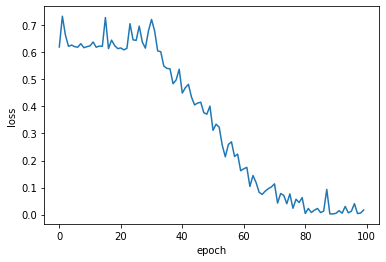

In [ ]:

plt.figure()
plt.plot(xx,loss_list)
plt.xlabel('epoch') 
plt.ylabel('loss')
plt.show()
l=[]
for i in range(len(loss_list)):
  l.append(float(loss_list[i].data))
with open("loss9.txt","w")as f:
  print(l,file=f)

In [ ]:
#误码率

torch.save(model.state_dict(),"para.pth")

In [ ]:
def greedy_decoder(model, enc_input, start_symbol):
    """
    For simplicity, a Greedy Decoder is Beam search when K=1. This is necessary for inference as we don't know the
    target sequence input. Therefore we try to generate the target input word by word, then feed it into the transformer.
    Starting Reference: http://nlp.seas.harvard.edu/2018/04/03/attention.html#greedy-decoding
    :param model: Transformer Model
    :param enc_input: The encoder input
    :param start_symbol: The start symbol. In this example it is 'S' which corresponds to index 4
    :return: The target input
    """
    enc_input=enc_input.cuda()
    enc_outputs = model.encoder(enc_input)
    dec_input = torch.zeros(1, 0).type_as(enc_input.data)
    dec_input=dec_input.cuda()
    terminal = False
    next_symbol = start_symbol
    for i in range(8):  
        a= torch.tensor([[next_symbol]],dtype=enc_input.dtype)
        a=a.cuda()      
        dec_input=torch.cat([dec_input.detach(),a],-1)
        dec_input=dec_input.cuda()
        dec_outputs, _, _ = model.decoder(dec_input, enc_input, enc_outputs)
        projected = model.projection(dec_outputs)
        prob = projected.squeeze(0).max(dim=-1, keepdim=False)[1]
        next_word = prob.data[-1]
        next_symbol = next_word
        #print(next_word)            
    return dec_input

In [ ]:
test_u = np.array(np.random.randint(0, 2, size = (5000, k)), dtype = np.float32)
test_x = np.array(polar_encode(test_u, N, k, -3), np.float32)
test_x = bpsk_modulation(test_x)
#print(test_x[0])
test_x = awgn_noise(test_x, noise_var)
test_x=np.around(test_x,1)
print(SNR)
print(test_x)

10.0
[[ 0.79  1.2  -1.11 ...  0.8  -0.83 -1.3 ]
 [-0.83 -1.37 -1.04 ...  0.87  0.96 -1.68]
 [-0.96  1.12  1.18 ... -1.   -1.76 -0.68]
 ...
 [ 1.75  0.56  0.94 ... -0.91  0.62 -0.73]
 [-0.77 -0.69  1.25 ...  0.49 -1.88  0.96]
 [-0.68  1.28  0.62 ...  0.51  0.99 -1.35]]


In [ ]:
print(test_u)

[[1. 1. 0. ... 0. 0. 1.]
 [0. 1. 1. ... 0. 0. 1.]
 [0. 1. 1. ... 0. 1. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 1. 1. 1.]]


In [ ]:
#将数据导入code.csv
writer=csv.writer(open('./testcode.csv','w'))
length_list=len(test_u)
i=0
while i!=length_list+1 :
    if(i==0):
      data='code'
      data2='encode'
    else:
      # print(i)
      data=test_u[i-1]
      data2=test_x[i-1]
    #print data
    i=i+1
    writer.writerow([data,data2])



In [ ]:
df = pd.read_csv("./testcode.csv", delimiter=',', header=None, names=['code','encode'])

answer=df.code.values
ques=df.encode.values
# #encode=encode[1:854]
answer=answer[1:]
ques=ques[1:]

In [ ]:
a, b, c = make_data(ques,answer)
test_data=MyDataSet(a,b,c)
test_loader=Data.DataLoader(test_data,batch_size,False)


In [ ]:
  #Test
acc=0
cnt=0
for enc_inputs, _, label in test_loader:
  #print(enc_inputs[:20])
  #print(label[:20])
  #print(label)
  #print(o
    correct=0
    total=0
    enc_inputs=enc_inputs.cuda()
    #print(len(enc_inputs))
    #print(src_vocab)
    for i in range(len(enc_inputs)):
        greedy_dec_input = greedy_decoder(model, enc_inputs[i].view(1, -1), start_symbol=tgt_vocab["S"])
        predict, _, _ = model(enc_inputs[i].view(1, -1), greedy_dec_input)
        #print(predict)
        a=label[i][:-1]
        for j in range(len(a)):
          a[j]=a[j]-1
        
        
        predict = predict.data.max(1, keepdim=True)[1]
        b=[idx2word[n.item()] for n in predict.squeeze()]
        for j in range(8):
          #print(b[j],a[j])
          #print(type(a[j]))
          c=1
          if b[j]=='0.':
            c=0
          if c==a[j]:  
            correct=correct+1
          if c!=a[j]:
            cnt=cnt+1
            print("real",a)
            print(enc_inputs[i], '->', [idx2word[n.item()] for n in predict.squeeze()])
          total=total+1
        
print("ber=",cnt/40000)

real tensor([0, 1, 1, 0, 1, 1, 0, 0])
tensor([331, 352, 187, 329, 338, 109, 314, 358, 308, 311, 261, 378, 349, 117,
        343, 342], device='cuda:0') -> ['0.', '1.', '0.', '0.', '1.', '1.', '0.', '0.']
real tensor([1, 0, 0, 1, 1, 1, 1, 0])
tensor([129, 160, 150, 396, 295, 337, 331, 177, 352, 320, 226, 161, 113, 173,
        124, 374], device='cuda:0') -> ['1.', '0.', '1.', '1.', '1.', '1.', '1.', '0.']
real tensor([0, 0, 0, 1, 0, 0, 1, 0])
tensor([327, 139, 319, 126, 182, 314, 136, 354, 331, 138, 347, 208, 160, 407,
        215, 344], device='cuda:0') -> ['0.', '0.', '0.', '1.', '0.', '1.', '0.', '1.']
real tensor([0, 0, 0, 1, 0, 0, 1, 0])
tensor([327, 139, 319, 126, 182, 314, 136, 354, 331, 138, 347, 208, 160, 407,
        215, 344], device='cuda:0') -> ['0.', '0.', '0.', '1.', '0.', '1.', '0.', '1.']
real tensor([0, 0, 0, 1, 0, 0, 1, 0])
tensor([327, 139, 319, 126, 182, 314, 136, 354, 331, 138, 347, 208, 160, 407,
        215, 344], device='cuda:0') -> ['0.', '0.', '0.', '1.', '0.'